In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random

#load data
countries = pd.read_csv('../data/processed/countries.csv')
matches = pd.read_csv('../data/processed/matches.csv')
leagues = pd.read_csv('../data/processed/leagues.csv')
teams = pd.read_csv('../data/processed/teams.csv')
#matches.dropna(inplace=True)
countries.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [2]:
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [3]:
leagues.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [4]:
teams.head()

,team_api_id,team_long_name
0,9987,KRC Genk
1,9993,Beerschot AC
2,10000,SV Zulte-Waregem
3,9994,Sporting Lokeren
4,9984,KSV Cercle Brugge


In [5]:
#select relevant countries and merge with leagues
selected_countries = ['England','France','Germany','Italy','Spain']
countries = countries[countries.name.isin(selected_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

In [6]:
#select relevant fields
matches = matches[matches.league_id.isin(leagues.id)]
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1.20,6.5,15.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,1.91,3.4,4.20
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,1.91,3.4,4.33


In [7]:
from scipy.stats import entropy

def match_entropy(row):
    odds = [row['B365H'],row['B365D'],row['B365A']]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)

#compute match entropy
matches['entropy'] = matches.apply(match_entropy,axis=1)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A,entropy
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00,0.738980
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1.20,6.5,15.00,0.641186
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67,0.975928
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,1.91,3.4,4.20,1.039730
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,1.91,3.4,4.33,1.036584


In [8]:
#compute mean entropy for every league in every season
entropy_means = matches.groupby(['season','league_id']).entropy.mean()
entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')
entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]
entropy_means.head(10)

,England,France,Germany,Italy,Spain
season,,,,,
2008/2009,0.984556,1.026638,1.004276,1.002201,1.010859
2009/2010,0.956496,1.013821,0.997925,1.006755,0.977810
2010/2011,0.983258,1.026236,1.016264,1.006029,0.975032
2011/2012,0.969593,1.024915,1.001298,1.003077,0.955339
2012/2013,0.981472,1.016116,0.993993,1.003565,0.970580
2013/2014,0.960473,1.004439,0.977500,0.992622,0.944218
2014/2015,0.980301,1.012495,0.985835,0.999100,0.933637
2015/2016,0.997819,1.013928,0.974657,0.985284,0.946813


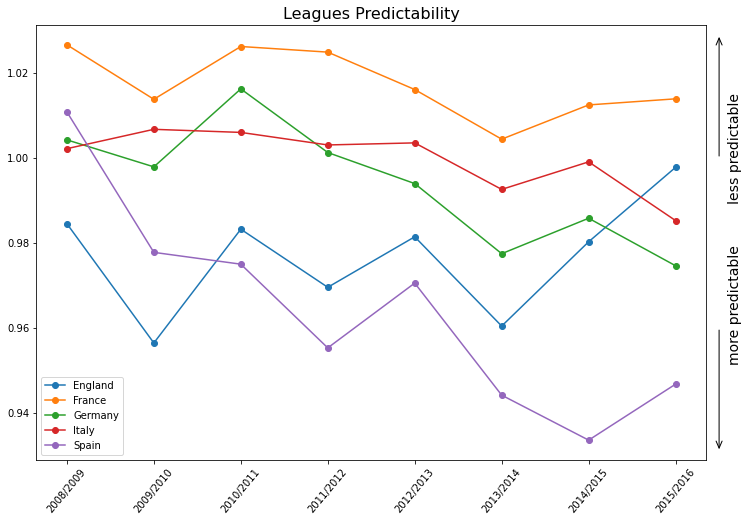

In [9]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=16)

#set ticks roatation
plt.xticks(rotation=50)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(matches.league_id.unique(),colors))

#remove x label
ax.set_xlabel('')

#locate legend
plt.legend(loc='lower left')

#add arrows
ax.annotate('', xytext=(7.5, 1),xy=(7.5, 1.029),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.5, 0.96),xy=(7.5, 0.931),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.6, 0.99), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.6, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')

plt.savefig('../reports/figures/leagues_pred.png', bbox_inches='tight',dpi=600)

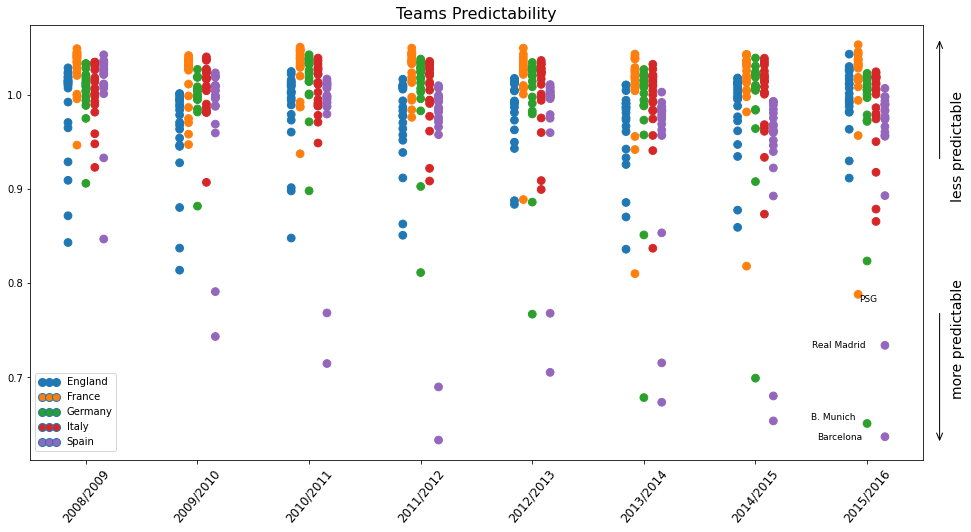

In [10]:
from matplotlib.lines import Line2D

offsets = [-0.16,-0.08,0,0.08,0.16]
offsets_mapping = dict(zip(colors_mapping.keys(),offsets))
y = []
x = []
c = []

i = -1
for season,season_df in matches.groupby('season'):
    i+=1
    for team,name in zip(teams.team_api_id,teams.team_long_name):
        team_df = season_df[(season_df.home_team_api_id==team)|(season_df.away_team_api_id==team)]
        team_entropy = team_df.entropy.mean()
        if team_entropy>0:
            league_id = team_df.league_id.values[0]
            x.append(i+offsets_mapping[league_id])
            y.append(team_entropy)
            c.append(colors_mapping[league_id])

plt.figure(figsize=(16,8))
plt.scatter(x,y,color=c,s=[60]*len(x))
plt.title('Teams Predictability', fontsize=16)

#create ticks and labels
ax = plt.gca()
plt.xlim((-0.5,7.5))
plt.xticks(np.arange(0,8,1),rotation=50)

#create grid
ax.set_xticklabels(entropy_means.index,fontsize=12)
for i in range(7):
    ax.axvline(x=0.5+i,ls='--',c='w')
ax.yaxis.grid(False)
ax.xaxis.grid(False)

#create legend
circles = []
labels = []
for league_id,name in zip(leagues.id,leagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[league_id]))
plt.legend(circles, labels, numpoints=3, loc=(0.005,0.02))

#add arrows
ax.annotate('', xytext=(7.65, 0.93),xy=(7.65, 1.06),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.65, 0.77),xy=(7.65, 0.63),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.75, 0.89), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.75, 0.68), annotation_clip=False,fontsize=14,rotation='vertical')

#add labels
ax.annotate('Barcelona', xy=(6.55, 0.634),fontsize=9)
ax.annotate('B. Munich', xy=(6.5, 0.655),fontsize=9)
ax.annotate('Real Madrid', xy=(6.51, 0.731),fontsize=9)
ax.annotate('PSG', xy=(6.93, 0.78),fontsize=9)

plt.savefig('../reports/figures/teams_pred.png', bbox_inches='tight',dpi=600)